# Bayesian analysis of the empirical saturation point (refactored version)

In [102]:
from modules.DataSets import GenericDataSet, NormDistDataSet, KernelDensityEstimate
from modules.EftPredictions import *
from modules.StatisticalModel import StatisticalModel
import matplotlib.backends.backend_pdf
from tqdm import tqdm

In [103]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set the location where pdf output will be stored.

In [104]:
import os
pdf_path = "./pdf"
if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)

## Constraints from density functional theory: data management

In [105]:
dft_constraints = {
    "Dutra_skyrme": GenericDataSet(filenames=["satpoints_dutra_skyrme.csv"]),
    "Kortelainen": GenericDataSet(filenames=["satpoints_kortelainen.csv"]),
    "Brown": GenericDataSet(filenames=["brown/satpoints_brown.csv"]),
    "Dutra_rmf": GenericDataSet(filenames=["satpoints_rmf_dutra_2014.csv"]),
    "FSU": NormDistDataSet(set_specifier="fsu_rmf"),
    "Schunck": KernelDensityEstimate(set_specifier="schunck")
}
# now add the saturation box from Drischler et al. (2016)
drischler = dft_constraints["Dutra_skyrme"] + dft_constraints["Kortelainen"]

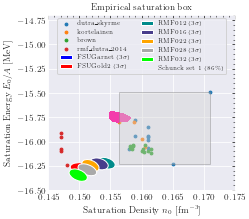

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 1.2*6.8*cm))
for key, val in dft_constraints.items():
    val.plot(ax=ax)
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]
INFO:pymc3:NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 47 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 47 seconds.


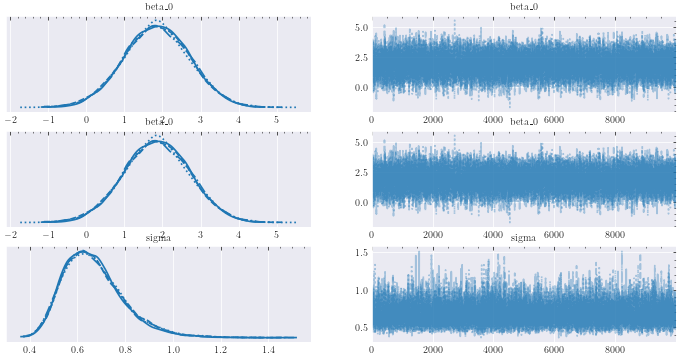

In [107]:
eft_pred = EftPredictions()
eft_pred.corner_plot()
eft_pred.plot(ax=ax)

In [108]:
fig.savefig(f"{pdf_path}/refactored_overview.pdf")

## Single universe as a test case

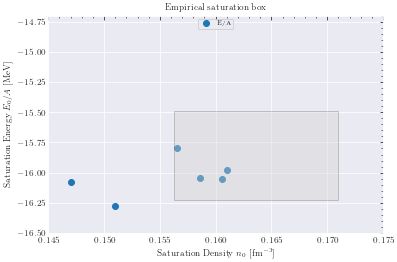

In [109]:
sampled_dft_constraints = pd.DataFrame()
for key, val in dft_constraints.items():
    sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

ax = sampled_dft_constraints.plot(x="rho0", y="E/A", linestyle="None", marker="o")
drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True)

In [110]:
sampled_dft_constraints  # one realization (aka "universe") for testing

,label,rho0,E/A,class,file
5,SkT1,0.161000,-15.980000,dutra_skyrme,satpoints_dutra_skyrme.csv
1,UNEDF0,0.160530,-16.056000,kortelainen,satpoints_kortelainen.csv
7,brown:8,0.158610,-16.045170,brown,brown/satpoints_brown.csv
2,BSR11,0.147000,-16.080000,rmf_dutra_2014,satpoints_rmf_dutra_2014.csv
0,FSUGold2,0.150939,-16.277503,fsu_rmf,data/Piekarewicz/FSUGold2/CovEllipse.com
3486,schunck:3,0.156571,-15.792983,schunck:3,data/Schunck/samples3.csv


In [111]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.01**2, 0], [0, 0.32**2]]),
                "kappa": 1, "nu": 4}  # TODO: this prior is way too uninformed for the "true" nuclear saturation point. Make it realistic.
spoint = StatisticalModel(data=sampled_dft_constraints,
                          quantities=["rho0", "E/A"],
                          prior_params=prior_params)
spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True)

sanity check based on predictive 'prior'
quantiles conj. prior: [[  0.1408755  -16.51118389]
 [  0.16002738 -15.89845132]
 [  0.17941046 -15.28849568]]
quantiles brute-force: [[  0.14068748 -16.51276576]
 [  0.1599937  -15.89999771]
 [  0.17932723 -15.28423546]]
passed: True


True

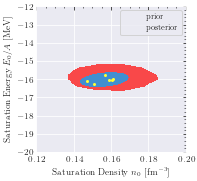

In [112]:
from modules.plot_helpers import *
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
spoint.plot(ax=ax, num_samples=500000)
fig.savefig(f"{pdf_path}/output.pdf")

## Multiple Universes
Now, let's average over different realizations ("universes").

Multi-universe sampling: 100%|██████████| 5/5 [25:11<00:00, 302.39s/it]


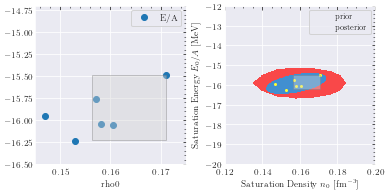

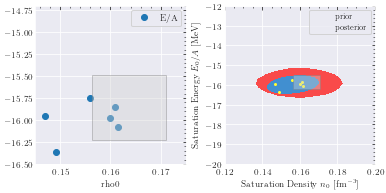

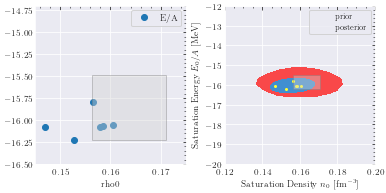

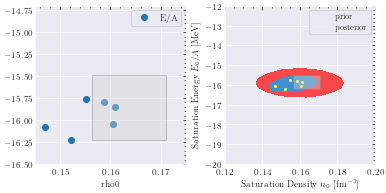

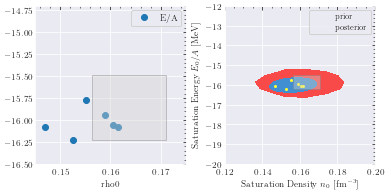

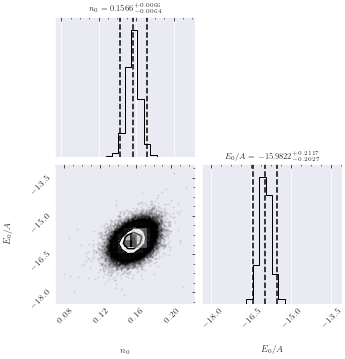

In [113]:
pdf = matplotlib.backends.backend_pdf.PdfPages(f"{pdf_path}/multi_universe_output.pdf")
num_realizations = 5
samples = pd.DataFrame()

for irealiz in tqdm(range(num_realizations), desc="Multi-universe sampling"):
    # set up canvas
    fig, axs = plt.subplots(1, 2, figsize=(2*6.8*cm, 6.8*cm), constrained_layout=True)

    # construct data set ("universe") for Bayesian inference
    sampled_dft_constraints = pd.DataFrame()
    for key, val in dft_constraints.items():
        sampled_dft_constraints = val.sample(df=sampled_dft_constraints)

    # plot raw data (left panel)
    sampled_dft_constraints.plot(ax=axs[0], x="rho0", y="E/A", linestyle="None", marker="o")
    for ax in axs:  # draw saturation box in both panels as a reference
        drischler.plot(ax=ax, plot_scatter=False, plot_box_estimate=True,
                       add_legend=False, add_axis_labels=False)
    axs[0].set_xlim(0.145, 0.175)
    axs[0].set_ylim(-16.5, -14.7)

    # perform Bayesian analysis
    spoint = StatisticalModel(data=sampled_dft_constraints,
                              quantities=["rho0", "E/A"],
                              prior_params=prior_params)
    #print(spoint.sanity_check(num_samples=100000, based_on="prior", do_print=True))

    # store data from current universe (for universe-averaging later on)
    tmp = spoint.sample_predictive_bf(return_predictive_only=False, based_on="posterior",
                                      num_samples=1, num_samples_mu_Sigma=100000)  # 100000
    tmp["universe"] = irealiz
    samples = pd.concat((samples, tmp))

    # plot predictive prior and predictive posterior (right panel)
    spoint.plot(ax=axs[1], num_samples=500000)  #500000
    pdf.savefig(fig)

# plot multi-universe average of the posterior predictive
names = ["predictive rho0", "predictive E/A"]
labels = [r"$n_0$", r"$E_0/A$"]
fig, axs = plt.subplots(2, 2, figsize=(2*6.8*cm, 2*6.8*cm))
corner.corner(samples, var_names=names, labels=labels,
              quantiles=(0.025, 0.5, 0.975),
              title_quantiles=(0.025, 0.5, 0.975),
              show_titles=True, title_fmt=".4f", title_kwargs={"fontsize": 8}, fig=fig)
drischler.plot(ax=axs[1, 0], plot_scatter=False, plot_box_estimate=True,
               add_legend=False, add_axis_labels=False)
pdf.savefig(fig)
pdf.close()

Let's take a look at the plain data from the different universes.

In [114]:
samples

,predictive rho0,predictive E/A,mu rho0,mu E/A,"Sigma (0,0)","Sigma (0,1)","Sigma (1,1)",universe
0,0.159868,-15.856777,0.150386,-16.140475,0.000238,0.003301,0.076243,0
1,0.166267,-15.980345,0.157973,-15.915478,0.000070,0.003305,0.209634,0
2,0.152008,-16.277313,0.155922,-15.972869,0.000028,0.000161,0.045467,0
3,0.164720,-16.148726,0.159114,-15.785982,0.000073,0.001019,0.040740,0
4,0.157738,-15.905159,0.154210,-15.949799,0.000108,0.002351,0.084293,0
...,...,...,...,...,...,...,...,...
99995,0.164112,-16.099518,0.157229,-16.026706,0.000029,0.000124,0.025483,4
99996,0.155238,-15.958327,0.153089,-15.980690,0.000027,0.000323,0.022125,4
99997,0.146694,-15.877554,0.150319,-15.916733,0.000067,0.000374,0.035392,4
99998,0.158612,-15.886217,0.153736,-16.001943,0.000023,0.000223,0.028011,4


Interesting! Look at the off-diagonal component of $\Sigma$, i.e., `Sigma (0,1)`. It's close to zero and changes sign. Why don't we obtain the saturation density and energy uncorrelated? Is that because of the chosen prior or prior paramaters?